# Malaria Cells Classification

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#from fastai.data_block import *
from fastai.vision import *
import pandas as pd

In [15]:
# Download and unzip the dataset from
# 'https://ceb.nlm.nih.gov/proj/malaria/cell_images.zip'
# to PATH
PATH = 'data/'
DATAPATH = f'{PATH}/cell_images/'

In [16]:
# Download and unpack the dataset, if not done yet.

In [17]:
!ls {DATAPATH}

Parasitized  Uninfected  models


In [18]:
files = get_files(f'{DATAPATH}', extensions='.png', recurse=True)
len(files)

27558

In [19]:
# Uncomment the following to get a sample from the dataset
#sample_size = 10000
#files = random.sample(files, sample_size)

In [20]:
# Get label from file_path -- folder's name
def get_label(file_path): return 'infected' if '/Parasitized/' in str(file_path) else 'clean'

In [21]:
bs=64 # Batch size
data = ImageDataBunch.from_name_func(f'{DATAPATH}', fnames=files, 
                                     label_func=get_label,      # Parasitized -> infected; Uninfected -> clean
                                     bs = bs,
                                     ds_tfms=get_transforms(), 
                                     size=170                   # resize all images
                                    ).normalize(imagenet_stats) 

In [22]:
df = pd.DataFrame(data.y.items)
df['category'] = df[0].replace({0:data.classes[0], 1:data.classes[1]})

In [23]:
data

ImageDataBunch;

Train: LabelList
y: CategoryList (22047 items)
[Category infected, Category infected, Category infected, Category infected, Category infected]...
Path: data/cell_images
x: ImageItemList (22047 items)
[Image (3, 169, 133), Image (3, 118, 127), Image (3, 133, 103), Image (3, 127, 121), Image (3, 115, 121)]...
Path: data/cell_images;

Valid: LabelList
y: CategoryList (5511 items)
[Category clean, Category infected, Category clean, Category infected, Category clean]...
Path: data/cell_images
x: ImageItemList (5511 items)
[Image (3, 130, 169), Image (3, 106, 124), Image (3, 145, 127), Image (3, 169, 145), Image (3, 142, 133)]...
Path: data/cell_images;

Test: None

In [24]:
df['category'].value_counts()

clean       11032
infected    11015
Name: category, dtype: int64

In [25]:
# infected cells ratio in the dataset or sample 
data.y.items.sum()/len(data.y.items)

0.4996144600172359

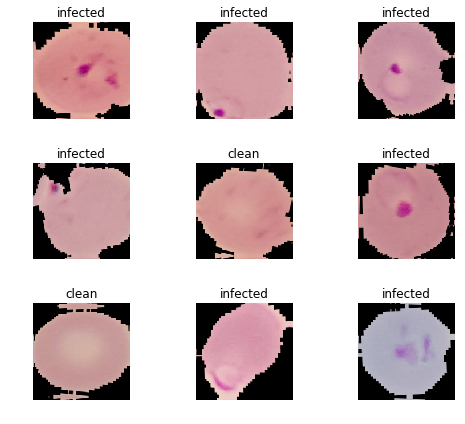

In [26]:
data.show_batch(rows=3, figsize=(7,6))

# Model 1 - -  ResNet-34

## ResNet-34. Stage 1 -- Training the last layer only

In [27]:
learn = create_cnn(data, models.resnet34, pretrained=True, metrics=accuracy)

In [28]:
learn

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (22047 items)
[Category infected, Category infected, Category infected, Category infected, Category infected]...
Path: data/cell_images
x: ImageItemList (22047 items)
[Image (3, 169, 133), Image (3, 118, 127), Image (3, 133, 103), Image (3, 127, 121), Image (3, 115, 121)]...
Path: data/cell_images;

Valid: LabelList
y: CategoryList (5511 items)
[Category clean, Category infected, Category clean, Category infected, Category clean]...
Path: data/cell_images
x: ImageItemList (5511 items)
[Image (3, 130, 169), Image (3, 106, 124), Image (3, 145, 127), Image (3, 169, 145), Image (3, 142, 133)]...
Path: data/cell_images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1,

In [29]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,accuracy
1,0.252428,0.177682,0.937761
2,0.179210,0.141670,0.952459
3,0.154940,0.112976,0.958810
4,0.132179,0.110817,0.958265
5,0.131507,0.100075,0.962620
6,0.111973,0.096983,0.964435
7,0.109729,0.095398,0.963890
8,0.117686,0.095875,0.964979


In [30]:
learn.save('stage-1')

## ResNet-34. Stage 1 -- Results analysis

In [31]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

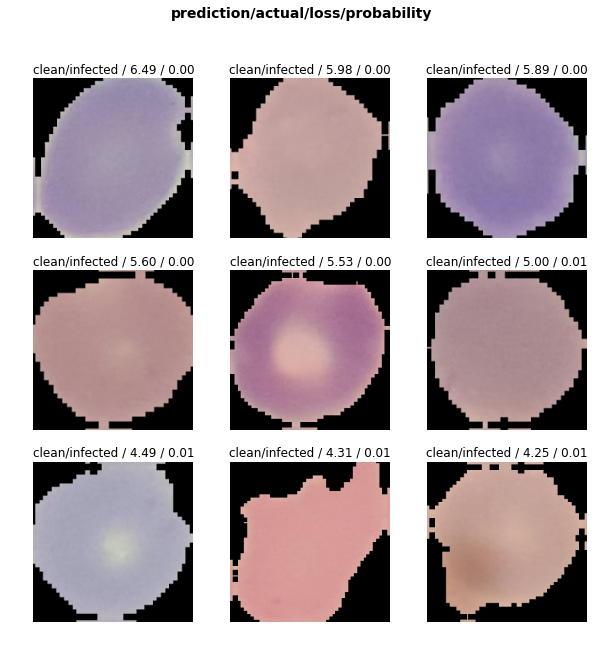

In [32]:
interp.plot_top_losses(9, figsize=(10,10))

In [33]:
doc(interp.plot_top_losses)

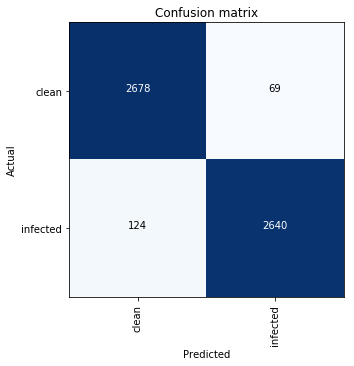

In [34]:
interp.plot_confusion_matrix(figsize=(5,5))

In [35]:
interp.most_confused(min_val=2)

[('infected', 'clean', 124), ('clean', 'infected', 69)]

## ResNet-34. Stage 2 -- Unfreezing all layers, fine-tuning, and choosing learning rate

In [36]:
learn.unfreeze() # Enable all layers of NN to learn -- set requires_grad = True

In [37]:
#learn.load('stage-1');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


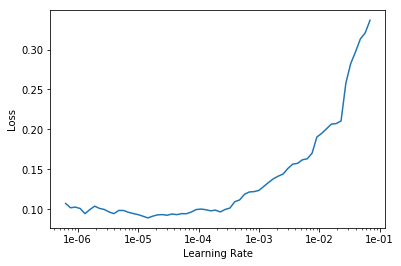

In [38]:
learn.lr_find();
learn.recorder.plot()

In [39]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-6,1e-5))

epoch,train_loss,valid_loss,accuracy
1,0.112082,0.093375,0.966068
2,0.113694,0.091406,0.966612
3,0.111754,0.089694,0.967157
4,0.103694,0.089652,0.966975


In [40]:
learn.save('stage-2')

## ResNet-34. Stage 2 -- Results analysis

In [41]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

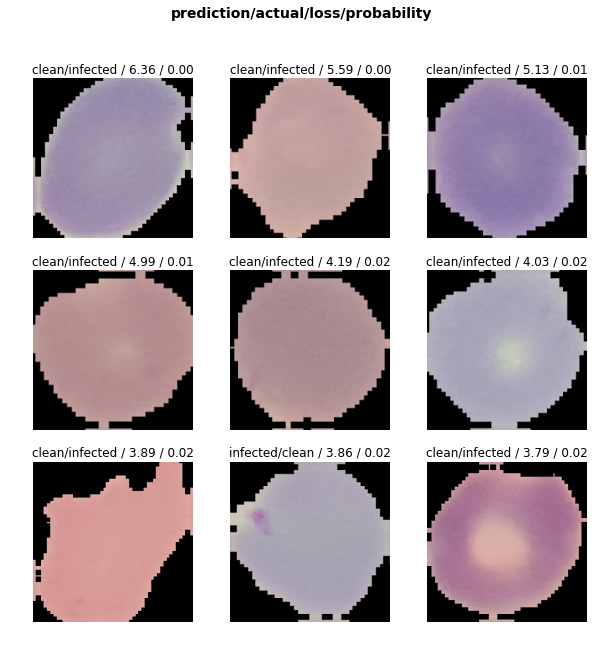

In [42]:
interp.plot_top_losses(9, figsize=(10,10))

In [43]:
doc(interp.plot_top_losses)

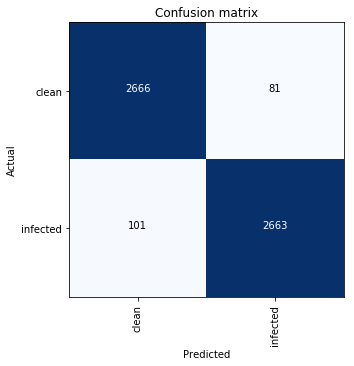

In [44]:
interp.plot_confusion_matrix(figsize=(5,5))

In [45]:
interp.most_confused(min_val=2)

[('infected', 'clean', 101), ('clean', 'infected', 81)]

# Model 2 - -  ResNet-50

## Stage 1. Training the last layer only

We'll use smaller batch size.

In [46]:
data = ImageDataBunch.from_name_func(f'{DATAPATH}', fnames=files, label_func=get_label, 
                                     bs=bs//2, 
                                     ds_tfms=get_transforms(), 
                                     size=170
                                     ).normalize(imagenet_stats)

In [47]:
learn = create_cnn(data, 
                   models.resnet50, 
                   pretrained=True, # Leave only the last layer with requires_grad = True
                   metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


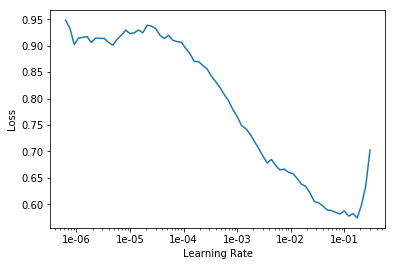

In [48]:
learn.lr_find()
learn.recorder.plot()

In [49]:
learn.fit_one_cycle(8, max_lr=1e-2)

epoch,train_loss,valid_loss,accuracy
1,0.185371,0.147972,0.951370
2,0.171672,0.137128,0.958084
3,0.144841,0.118323,0.958084
4,0.145557,0.136532,0.950281
5,0.120406,0.104959,0.964072
6,0.113034,0.096068,0.967338
7,0.093753,0.093459,0.968064
8,0.078344,0.091585,0.967882


In [50]:
learn.save('stage-1-50')

## ResNet-50. Stage 1 -- Analyzing the results

In [51]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

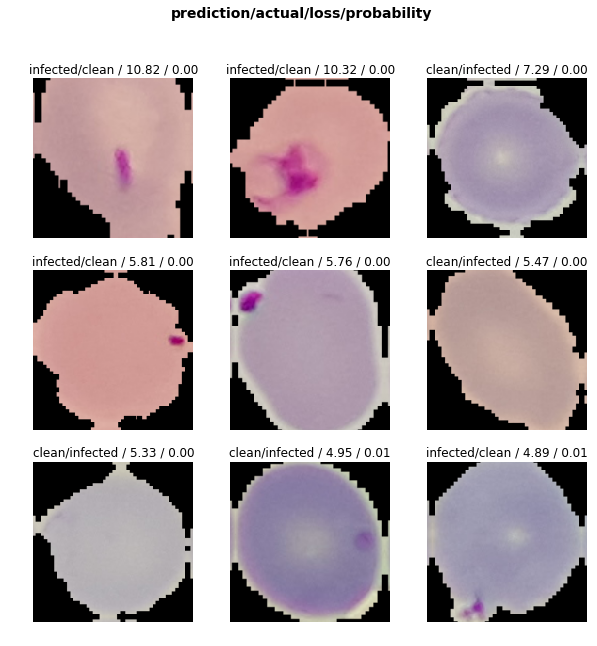

In [52]:
interp.plot_top_losses(9, figsize=(10,10))

In [53]:
doc(interp.plot_top_losses)

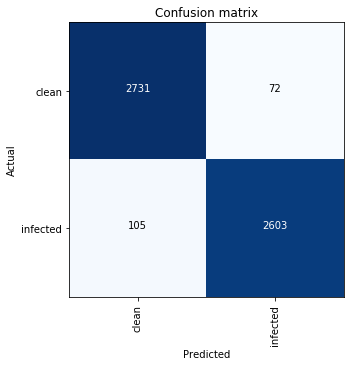

In [54]:
interp.plot_confusion_matrix(figsize=(5,5)) #, dpi=60)

In [55]:
interp.most_confused(min_val=2)

[('infected', 'clean', 105), ('clean', 'infected', 72)]

## ResNet-50. Stage 2 -- Unfreezing, fine-tuning, and learning rates

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


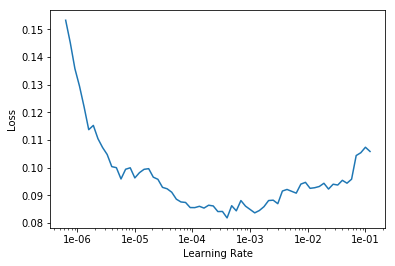

In [83]:
learn.lr_find()
learn.recorder.plot()

In [56]:
learn.unfreeze() # Enable all layers of NN to learn -- set requires_grad = True
learn.fit_one_cycle(4, max_lr=slice(2e-5,1e-4))

epoch,train_loss,valid_loss,accuracy
1,0.102057,0.098065,0.966249
2,0.112881,0.095750,0.965342
3,0.095904,0.092911,0.967701
4,0.067358,0.089976,0.966975


## ResNet-50. Stage 2 -- Analyzing the results

In [57]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

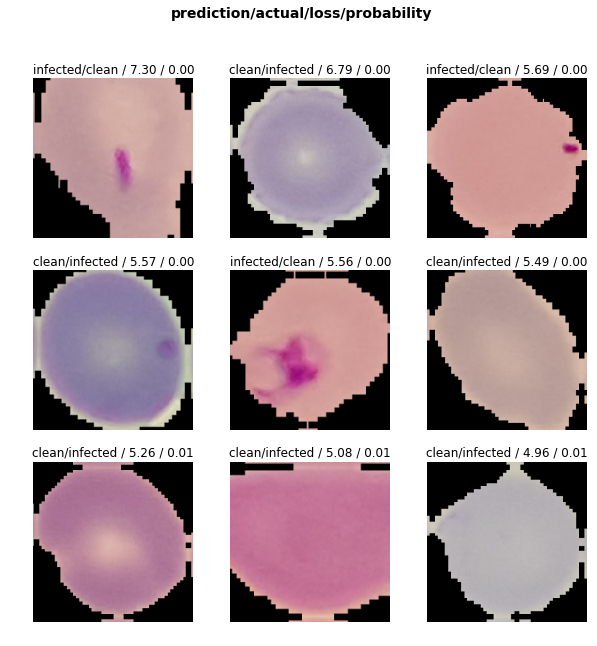

In [58]:
interp.plot_top_losses(9, figsize=(10,10))

In [59]:
doc(interp.plot_top_losses)

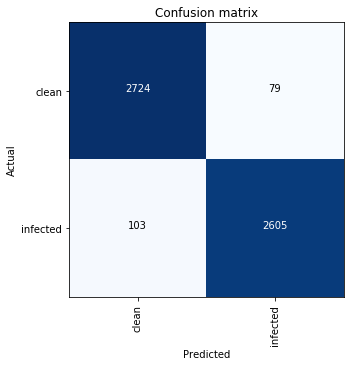

In [60]:
interp.plot_confusion_matrix(figsize=(5,5)) #, dpi=60)

In [61]:
interp.most_confused(min_val=2)

[('infected', 'clean', 103), ('clean', 'infected', 79)]

In [62]:
learn.save('stage-2-50')